In [27]:
import warnings
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.metrics import NormalDistributionLoss

warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)

def main():
    pl.seed_everything(42, workers=True)

    # 1. 加载和预处理
    data = pd.read_csv("/kaggle/input/aaplll/stock_data.csv")
    data["Date"] = pd.to_datetime(data["Date"], format="%Y/%m/%d")
    data = data.sort_values("Date").reset_index(drop=True)
    data["time_idx"] = data.index + 1
    data["static"] = data["stock_id"]
    
    # 提取更多时间特征
    data["day_of_week"] = data["Date"].dt.dayofweek
    data["day_of_week"] = data["day_of_week"].astype(str)  # 或者：.astype("category")
    data["day_of_month"] = data["Date"].dt.day
    data["week_of_year"] = data["Date"].dt.isocalendar().week.astype(int)

    max_encoder_length = 50
    max_prediction_length = 10
    training_cutoff = data["time_idx"].max() - (max_encoder_length + max_prediction_length)
    
    # 2. 定义训练集
    training = TimeSeriesDataSet(
        data=data[data.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="Close",
        group_ids=["stock_id"],
        categorical_encoders={
            "stock_id": NaNLabelEncoder().fit(data["stock_id"])
        },
        static_categoricals=["static"],
        time_varying_known_categoricals=["day_of_week"],  # 示例
        time_varying_known_reals=["time_idx", "day_of_month", "week_of_year"],  # 示例
        time_varying_unknown_reals=["Close"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="log"),
        add_relative_time_idx=True,
        add_target_scales=True,
        randomize_length=True,  # 或者 False，看实际情况
    )

    # 3. 定义验证集
    validation_data = data[data.time_idx > training_cutoff]
    validation = TimeSeriesDataSet.from_dataset(
        training,
        validation_data,
        stop_randomization=True,
    )

    train_dataloader = training.to_dataloader(
        train=True, batch_size=128, num_workers=20, persistent_workers=True
    )
    val_dataloader = validation.to_dataloader(
        train=False, batch_size=128, num_workers=20, persistent_workers=True
    )

    # 回调
    early_stop_callback = EarlyStopping(
        monitor="val_loss", min_delta=1e-4, patience=100, verbose=False, mode="min"
    )
    lr_logger = LearningRateMonitor()
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints/",
        filename="deepar-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min",
    )

    # 4. Trainer
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu", 
        devices="auto",
        precision="16-mixed",  # 尝试混合精度
        gradient_clip_val=0.1,
        callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    )

    # 5. DeepAR 模型
    deepar = DeepAR.from_dataset(
        training,
        learning_rate=0.01,   # 调低初始学习率
        hidden_size=128,      # 增大网络容量
        dropout=0.1,
        loss=NormalDistributionLoss(),
        log_interval=10,
        log_val_interval=5,
    )

    print(f"Number of parameters in network: {deepar.size() / 1e3:.1f}k")

    # 6. 开始训练
    trainer.fit(
        deepar,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # 7. 评估
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    predictions = deepar.predict(val_dataloader)
    device = predictions.device
    actuals = actuals.to(device)
    mae = (actuals - predictions).abs().mean()
    print(f"Mean absolute error of model: {mae.item():.4f}")

if __name__ == '__main__':
    main()

INFO: Seed set to 42
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:2

Number of parameters in network: 205.1k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
Exception ignored in: <function _ConnectionBase.__del__ at 0x7d9bfa11da80>
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 133, in __del__
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file de

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean absolute error of model: 18.0527


In [2]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [4]:
!pip install pytorch-forecasting

In [22]:
import warnings
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE

# 忽略 pandas 的 SettingWithCopyWarning
warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)

def main():
    # 设置随机种子，确保结果可复现
    pl.seed_everything(42, workers=True)

    # 1. 加载数据
    data = pd.read_csv("/kaggle/input/vhzmdd/AAPL_stock_data_with_indicators.csv")

    # 2. 数据预处理
    data["Date"] = pd.to_datetime(data["Date"], format="%Y/%m/%d")
    data = data.sort_values("Date").reset_index(drop=True)
    data["time_idx"] = data.index + 1  # 时间索引从1开始
    data["stock_id"] = "AAPL"
    data["static"] = data["stock_id"]

    drop_cols = [col for col in data.columns if "#NAME?" in col]
    if drop_cols:
        print(f"剔除异常列: {drop_cols}")
        data = data.drop(columns=drop_cols)

    data = data.fillna(method='ffill')

    # 3. 定义 encoder 和 decoder 的步长
    max_encoder_length = 30
    max_prediction_length = 1

    training_cutoff = data["time_idx"].max() - (max_encoder_length + max_prediction_length)
    print(f"数据总长度: {data['time_idx'].max()}, 训练截止点: {training_cutoff}")

    # 4. 定义额外的技术指标
    additional_features = [
        "Volume", "SMA_20", "EMA_20", "RSI_14",
        "BB_Middle", "BB_Upper", "BB_Lower", "EMA_12", "EMA_26",
        "MACD", "%K", "%D", "Momentum", "WMA_20",
        "TRIX", "VWAP", "CCI", "Bias", "RVI", "Williams %R", "MFI_14",
    ]
    known_reals = ["time_idx"] + additional_features

    # 5. 划分训练集和验证集
    training_data = data[data.time_idx <= training_cutoff]
    validation_data = data[data.time_idx > training_cutoff]
    print(f"验证集数量: {len(validation_data)}")

    training_dataset = TimeSeriesDataSet(
        data=training_data,
        time_idx="time_idx",
        target="Close",
        group_ids=["stock_id"],
        categorical_encoders={"stock_id": NaNLabelEncoder().fit(data["stock_id"])},
        static_categoricals=["static"],
        time_varying_known_reals=known_reals,
        time_varying_unknown_reals=["Close"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="softplus"),
        add_relative_time_idx=True,
        add_target_scales=True,
        randomize_length=None,
    )

    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset,
        validation_data,
        stop_randomization=True,
    )

    batch_size = 64
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

    early_stop_callback = EarlyStopping(
        monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min"
    )
    lr_logger = LearningRateMonitor()

    trainer = pl.Trainer(
        max_epochs=200,
        accelerator="gpu",   # 如果没有 GPU，可设为 "cpu"
        devices="auto",
        gradient_clip_val=0.1,
        limit_train_batches=30,
        limit_val_batches=3,
        callbacks=[lr_logger, early_stop_callback],
    )

    # 构造 TFT 模型，设置 output_size 为 1，仅输出中位数预测
    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=0.03,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=1,
        loss=MAE(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    print(f"模型参数数量: {tft.size() / 1e3:.1f}k")

    torch.set_num_threads(10)

    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # 预测时确保两边的张量在同一设备上
    predictions = tft.predict(val_dataloader, mode="prediction")
    actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
    actuals = actuals.to(predictions.device)  # 将实际值移动到 predictions 的设备上
    mae = (actuals - predictions).abs().mean()
    print(f"模型平均绝对误差 (MAE): {mae.item():.4f}")

if __name__ == '__main__':
    main()

INFO: Seed set to 42
/tmp/ipykernel_125/1226449937.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


剔除异常列: ['#NAME?', '#NAME?.1']
数据总长度: 1437, 训练截止点: 1406
验证集数量: 31


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings              

模型参数数量: 48.7k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 28.895


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 13.114 >= min_delta = 0.0001. New best score: 15.782


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.192 >= min_delta = 0.0001. New best score: 13.590


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 7.625 >= min_delta = 0.0001. New best score: 5.965


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.242 >= min_delta = 0.0001. New best score: 1.723


Validation: |          | 0/? [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.149 >= min_delta = 0.0001. New best score: 0.574


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.392 >= min_delta = 0.0001. New best score: 0.182


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 0.182. Signaling Trainer to stop.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


模型平均绝对误差 (MAE): 1.7601


In [38]:
import warnings
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder

# 忽略 pandas 的 SettingWithCopyWarning
warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)

def main():
    # 设置随机种子，确保结果可复现
    pl.seed_everything(42, workers=True)

    # 1. 加载数据（使用 Kaggle 上的文件路径）
    file_path = "/kaggle/input/vhzmdd/AAPL_stock_data_with_indicators.csv"
    data = pd.read_csv(file_path)

    # 2. 数据预处理
    # 转换日期格式，注意日期格式需和 CSV 文件一致
    data["Date"] = pd.to_datetime(data["Date"], format="%Y/%m/%d")
    data = data.sort_values("Date").reset_index(drop=True)
    data["time_idx"] = data.index + 1  # 时间索引从 1 开始
    # 假设数据只包含单只股票，将 stock_id 固定为 "AAPL"
    data["stock_id"] = "AAPL"
    data["static"] = data["stock_id"]

    # 剔除列名中包含异常字符串（如 "#NAME?"）的列
    drop_cols = [col for col in data.columns if "#NAME?" in col]
    if drop_cols:
        print(f"剔除异常列: {drop_cols}")
        data = data.drop(columns=drop_cols)

    # 前向填充缺失值
    data = data.fillna(method='ffill')

    # 3. 定义采样参数
    max_encoder_length = 30
    max_prediction_length = 2
    training_cutoff = data["time_idx"].max() - (max_encoder_length + max_prediction_length)
    print(f"数据总长度: {data['time_idx'].max()}, 训练截止点: {training_cutoff}")

    # 4. 定义额外技术指标（确保与 CSV 列名完全一致）
    additional_features = [
        "Open", "High", "Low", "Volume", "SMA_20", "EMA_20", "RSI_14",
        "BB_Middle", "BB_Upper", "BB_Lower", "EMA_12", "EMA_26",
        "MACD", "MACD_Signal", "ATR_14", "%K", "%D", "Momentum", "WMA_20",
        "TR", "DM+", "DM-", "DX", "ADX_14", "SMA_Smooth_20", "Volatility",
        "Upper_Price_Channel", "Lower_Price_Channel", "Keltner_Middle",
        "Keltner_Upper", "Keltner_Lower"
    ]
    known_reals = ["time_idx"] + additional_features

    # 5. 构造训练集与验证集
    training_data = data[data.time_idx <= training_cutoff]
    validation_data = data[data.time_idx > training_cutoff]
    print(f"验证集数量: {len(validation_data)}")

    training_dataset = TimeSeriesDataSet(
        data=training_data,
        time_idx="time_idx",
        target="Close",
        group_ids=["stock_id"],
        categorical_encoders={"stock_id": NaNLabelEncoder().fit(data["stock_id"])},
        static_categoricals=["static"],
        time_varying_known_reals=known_reals,         # 使用额外的技术指标
        time_varying_unknown_reals=["Close"],           # 目标为 Close
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="softplus"),
        add_relative_time_idx=True,
        add_target_scales=True,
        randomize_length=None,
    )

    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset,
        validation_data,
        stop_randomization=True,
    )

    # 6. 构造 DataLoader
    batch_size = 64
    train_dataloader = training_dataset.to_dataloader(
        train=True, batch_size=batch_size, num_workers=2, persistent_workers=True
    )
    val_dataloader = validation_dataset.to_dataloader(
        train=False, batch_size=batch_size, num_workers=2, persistent_workers=True
    )

    # 7. 定义回调函数和日志记录
    early_stop_callback = EarlyStopping(
        monitor="val_loss", min_delta=1e-4, patience=1, verbose=True, mode="min"
    )
    lr_logger = LearningRateMonitor()
    tensorboard_logger = TensorBoardLogger("lightning_logs")

    trainer = pl.Trainer(
        max_epochs=200,
        accelerator="gpu",   # 使用 GPU，如无 GPU 则设置为 "cpu"
        devices=1,
        gradient_clip_val=0.1,
        limit_train_batches=30,  # 调试时每个 epoch 限制 30 个批次
        callbacks=[lr_logger, early_stop_callback],
        logger=tensorboard_logger
    )

    # 8. 构造 TemporalFusionTransformer 模型
    # 此处使用 QuantileLoss，默认设置量化分位数为 [0.1, 0.5, 0.9]
    # 可根据需要调整 hidden_size、dropout、hidden_continuous_size 等参数以提高预测精度
    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        hidden_size=32,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=16,
        loss=QuantileLoss(),
        log_interval=2,
        learning_rate=0.03,
        reduce_on_plateau_patience=4
    )
    print(f"模型参数数量: {tft.size() / 1e3:.1f}k")

    torch.set_num_threads(10)

    # 9. 开始训练
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # 10. 验证集预测与误差计算
    # 使用 "quantiles" 模式获得预测，注意不要传入多余的 quantiles 关键字参数
    predictions = tft.predict(val_dataloader, mode="quantiles")
    # 默认 QuantileLoss 设置了三个 quantiles：[0.1, 0.5, 0.9]，因此预测输出 shape 为 [batch, prediction_length, 3]
    # 选取中位数（quantile=0.5）对应的预测，即取索引 1 的值
    median_predictions = predictions[..., 1]
    # 拼接批次中的实际目标值，并确保在同一设备上
    actuals = torch.cat([y for x, (y, _) in iter(val_dataloader)])
    actuals = actuals.to(median_predictions.device)
    mae = (actuals - median_predictions).abs().mean()
    print(f"模型平均绝对误差 (MAE): {mae.item():.4f}")

if __name__ == '__main__':
    main()

INFO: Seed set to 42
/tmp/ipykernel_125/2146841726.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


剔除异常列: ['#NAME?', '#NAME?.1']
数据总长度: 1437, 训练截止点: 1405
验证集数量: 32


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      

模型参数数量: 222.9k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 6.692


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.113 >= min_delta = 0.0001. New best score: 2.580


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 2.580. Signaling Trainer to stop.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


模型平均绝对误差 (MAE): 15.0787


In [43]:
import warnings
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM

# 忽略 pandas 的 SettingWithCopyWarning
warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)


class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, prediction_length, num_layers=1, lr=1e-3):
        """
        :param input_size: 输入特征数
        :param hidden_size: LSTM 隐藏层维度
        :param prediction_length: 预测区间长度
        :param num_layers: LSTM 层数
        :param lr: 学习率
        """
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        # 使用 pytorch_forecasting 中的 LSTM 层（设置 batch_first=True）
        self.lstm = ForecastingLSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )
        # 使用全连接层，将最后的隐藏状态映射到预测区间
        self.fc = torch.nn.Linear(hidden_size, prediction_length)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, x):
        """
        前向传播：使用 x["encoder_cont"] (形状为 (batch, encoder_length, num_features))
        """
        encoder_input = x["encoder_cont"]
        # lstm_out: (batch, encoder_length, hidden_size)
        # h_n: (num_layers, batch, hidden_size)
        _, (h_n, _) = self.lstm(encoder_input)
        # 使用最后一层隐藏状态 (batch, hidden_size)
        last_hidden = h_n[-1]
        prediction = self.fc(last_hidden)  # (batch, prediction_length)
        prediction = prediction.unsqueeze(-1)  # (batch, prediction_length, 1)
        return prediction

    def training_step(self, batch, batch_idx):
        x, (y, weight) = batch
        y_hat = self(x)
        # 调整目标维度为 (batch, prediction_length, 1)
        # 若 y 的形状不符合要求，则进行变换
        if y.dim() == 2:
            y = y.unsqueeze(-1)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, (y, weight) = batch
        y_hat = self(x)
        if y.dim() == 2:
            y = y.unsqueeze(-1)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=3, factor=0.5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1,
            }
        }


def main():
    pl.seed_everything(42, workers=True)

    # 1. 加载数据（使用 Kaggle 上的文件路径，新数据需包含丰富的技术指标）
    file_path = "/kaggle/input/vhzmdd/AAPL_stock_data_with_indicators.csv"
    data = pd.read_csv(file_path)

    # 2. 数据预处理
    # 将日期转换为 datetime 类型，并按照日期排序
    data["Date"] = pd.to_datetime(data["Date"], format="%Y/%m/%d")
    data = data.sort_values("Date").reset_index(drop=True)
    data["time_idx"] = data.index + 1  # 构造时间索引，从 1 开始
    # 假设数据只包含单只股票，将 stock_id 固定为 "AAPL"
    data["stock_id"] = "AAPL"
    data["static"] = data["stock_id"]

    # 剔除列名中包含异常字符串（如 "#NAME?"）的列
    drop_cols = [col for col in data.columns if "#NAME?" in col]
    if drop_cols:
        print(f"剔除异常列: {drop_cols}")
        data = data.drop(columns=drop_cols)

    # 前向填充缺失值
    data = data.fillna(method='ffill')

    # 3. 设置采样参数
    max_encoder_length = 60
    max_prediction_length = 1
    training_cutoff = data["time_idx"].max() - (max_encoder_length + max_prediction_length)
    print(f"数据总长度: {data['time_idx'].max()}, 训练截止点: {training_cutoff}")

    # 4. 定义额外技术指标（请确保 CSV 文件中包含对应的列）
    additional_features = [
        "Open", "High", "Low", "Volume", "SMA_20", "EMA_20", "RSI_14",
        "BB_Middle", "BB_Upper", "BB_Lower", "EMA_12", "EMA_26",
        "MACD", "MACD_Signal", "ATR_14", "%K", "%D", "Momentum", "WMA_20",
    ]
    # 将时间索引与额外指标合并
    known_reals = ["time_idx"] + additional_features

    # 5. 构造训练集与验证集数据集
    training_data = data[data.time_idx <= training_cutoff]
    validation_data = data[data.time_idx > training_cutoff]

    print(f"验证集数量: {len(validation_data)}")

    training_dataset = TimeSeriesDataSet(
        data=training_data,
        time_idx="time_idx",
        target="Close",
        group_ids=["stock_id"],
        categorical_encoders={"stock_id": NaNLabelEncoder().fit(data["stock_id"])},
        static_categoricals=["static"],
        time_varying_known_reals=known_reals,         # 使用额外技术指标作为已知特征
        time_varying_unknown_reals=["Close"],           # 目标为 Close
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="softplus"),
        add_relative_time_idx=True,
        add_target_scales=True,
        randomize_length=None,
    )

    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset,
        validation_data,
        stop_randomization=True,
    )

    # 6. 构造 DataLoader
    batch_size = 64
    train_dataloader = training_dataset.to_dataloader(
        train=True, batch_size=batch_size, num_workers=2, persistent_workers=True
    )
    val_dataloader = validation_dataset.to_dataloader(
        train=False, batch_size=batch_size, num_workers=2, persistent_workers=True
    )

    # 7. 定义回调函数与日志记录
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
    lr_logger = LearningRateMonitor(logging_interval="epoch")
    
    trainer = pl.Trainer(
        max_epochs=300,
        accelerator="gpu",  # 如无 GPU，请设置为 "cpu"
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[lr_logger, early_stop_callback],
    )

    # 打印输入特征数
    sample_batch = next(iter(train_dataloader))
    input_size = sample_batch[0]["encoder_cont"].shape[-1]
    print(f"Input feature size for LSTM: {input_size}")

    # 8. 构造 LSTM 模型
    lstm_model = LSTMModel(
        input_size=input_size,
        hidden_size=128,
        prediction_length=max_prediction_length,
        num_layers=1,
        lr=1e-3
    )
    total_params = sum(p.numel() for p in lstm_model.parameters())
    print(f"Number of parameters in network: {total_params/1e3:.1f}k")

    torch.set_num_threads(10)
    trainer.fit(lstm_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # 9. 评估阶段：注意预测和实际值均为归一化后的结果
    lstm_model.eval()
    predictions_list = []
    actuals_list = []
    with torch.no_grad():
        for batch in val_dataloader:
            x, (y, weight) = batch
            y_hat = lstm_model(x)
            predictions_list.append(y_hat)
            actuals_list.append(y)
    predictions = torch.cat(predictions_list, dim=0)
    actuals = torch.cat(actuals_list, dim=0)
    mae = (actuals - predictions).abs().mean()
    print(f"Mean absolute error: {mae.item():.4f}")

if __name__ == '__main__':
    main()

INFO: Seed set to 42
/tmp/ipykernel_125/3002250319.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


剔除异常列: ['#NAME?', '#NAME?.1']
数据总长度: 1437, 训练截止点: 1376
验证集数量: 61


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm    | LSTM    | 78.8 K | train
1 | fc      | Linear  | 129    | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
79.0 K    Trainable params
0         Non-trainable params
79.0 K    Total params
0.316     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Input feature size for LSTM: 24
Number of parameters in network: 79.0k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 49251.840


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1900.668 >= min_delta = 0.0001. New best score: 47351.172


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1380.590 >= min_delta = 0.0001. New best score: 45970.582


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1212.141 >= min_delta = 0.0001. New best score: 44758.441


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1128.719 >= min_delta = 0.0001. New best score: 43629.723


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1093.164 >= min_delta = 0.0001. New best score: 42536.559


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1067.004 >= min_delta = 0.0001. New best score: 41469.555


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1045.383 >= min_delta = 0.0001. New best score: 40424.172


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1038.738 >= min_delta = 0.0001. New best score: 39385.434


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1025.867 >= min_delta = 0.0001. New best score: 38359.566


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1005.625 >= min_delta = 0.0001. New best score: 37353.941


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1014.242 >= min_delta = 0.0001. New best score: 36339.699


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 990.508 >= min_delta = 0.0001. New best score: 35349.191


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 969.730 >= min_delta = 0.0001. New best score: 34379.461


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 951.754 >= min_delta = 0.0001. New best score: 33427.707


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 935.352 >= min_delta = 0.0001. New best score: 32492.355


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 919.828 >= min_delta = 0.0001. New best score: 31572.527


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 904.863 >= min_delta = 0.0001. New best score: 30667.664


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 890.289 >= min_delta = 0.0001. New best score: 29777.375


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 875.979 >= min_delta = 0.0001. New best score: 28901.396


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 861.891 >= min_delta = 0.0001. New best score: 28039.506


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 847.961 >= min_delta = 0.0001. New best score: 27191.545


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 834.164 >= min_delta = 0.0001. New best score: 26357.381


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 820.486 >= min_delta = 0.0001. New best score: 25536.895


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 806.904 >= min_delta = 0.0001. New best score: 24729.990


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 793.383 >= min_delta = 0.0001. New best score: 23936.607


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 779.920 >= min_delta = 0.0001. New best score: 23156.688


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 766.535 >= min_delta = 0.0001. New best score: 22390.152


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 752.930 >= min_delta = 0.0001. New best score: 21637.223


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 736.418 >= min_delta = 0.0001. New best score: 20900.805


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 722.805 >= min_delta = 0.0001. New best score: 20178.000


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 708.758 >= min_delta = 0.0001. New best score: 19469.242


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 699.549 >= min_delta = 0.0001. New best score: 18769.693


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 687.314 >= min_delta = 0.0001. New best score: 18082.379


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 674.328 >= min_delta = 0.0001. New best score: 17408.051


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 661.031 >= min_delta = 0.0001. New best score: 16747.020


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 648.039 >= min_delta = 0.0001. New best score: 16098.980


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 633.447 >= min_delta = 0.0001. New best score: 15465.533


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 620.389 >= min_delta = 0.0001. New best score: 14845.145


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 608.444 >= min_delta = 0.0001. New best score: 14236.700


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 595.834 >= min_delta = 0.0001. New best score: 13640.866


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 582.690 >= min_delta = 0.0001. New best score: 13058.176


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 570.197 >= min_delta = 0.0001. New best score: 12487.979


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 557.274 >= min_delta = 0.0001. New best score: 11930.704


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 543.498 >= min_delta = 0.0001. New best score: 11387.206


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 528.374 >= min_delta = 0.0001. New best score: 10858.832


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 517.463 >= min_delta = 0.0001. New best score: 10341.369


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 505.134 >= min_delta = 0.0001. New best score: 9836.235


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 491.746 >= min_delta = 0.0001. New best score: 9344.489


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 478.771 >= min_delta = 0.0001. New best score: 8865.719


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 465.964 >= min_delta = 0.0001. New best score: 8399.755


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 453.674 >= min_delta = 0.0001. New best score: 7946.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 440.958 >= min_delta = 0.0001. New best score: 7505.123


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 425.891 >= min_delta = 0.0001. New best score: 7079.231


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 413.950 >= min_delta = 0.0001. New best score: 6665.281


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 396.668 >= min_delta = 0.0001. New best score: 6268.613


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 382.458 >= min_delta = 0.0001. New best score: 5886.155


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 369.082 >= min_delta = 0.0001. New best score: 5517.074


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 358.691 >= min_delta = 0.0001. New best score: 5158.383


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 345.238 >= min_delta = 0.0001. New best score: 4813.145


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 336.388 >= min_delta = 0.0001. New best score: 4476.757


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 318.997 >= min_delta = 0.0001. New best score: 4157.760


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 301.353 >= min_delta = 0.0001. New best score: 3856.407


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 287.005 >= min_delta = 0.0001. New best score: 3569.402


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 282.220 >= min_delta = 0.0001. New best score: 3287.182


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 256.446 >= min_delta = 0.0001. New best score: 3030.736


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 228.815 >= min_delta = 0.0001. New best score: 2801.922


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 202.853 >= min_delta = 0.0001. New best score: 2599.069


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 206.298 >= min_delta = 0.0001. New best score: 2392.771


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 187.252 >= min_delta = 0.0001. New best score: 2205.519


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 167.585 >= min_delta = 0.0001. New best score: 2037.934


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 146.651 >= min_delta = 0.0001. New best score: 1891.282


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 150.718 >= min_delta = 0.0001. New best score: 1740.565


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 121.306 >= min_delta = 0.0001. New best score: 1619.259


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 125.672 >= min_delta = 0.0001. New best score: 1493.587


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 114.298 >= min_delta = 0.0001. New best score: 1379.289


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 100.365 >= min_delta = 0.0001. New best score: 1278.923


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 94.300 >= min_delta = 0.0001. New best score: 1184.624


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 82.792 >= min_delta = 0.0001. New best score: 1101.832


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 88.662 >= min_delta = 0.0001. New best score: 1013.169


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 73.332 >= min_delta = 0.0001. New best score: 939.837


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 75.434 >= min_delta = 0.0001. New best score: 864.404


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 57.756 >= min_delta = 0.0001. New best score: 806.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 64.201 >= min_delta = 0.0001. New best score: 742.446


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 56.605 >= min_delta = 0.0001. New best score: 685.841


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 59.208 >= min_delta = 0.0001. New best score: 626.633


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 57.001 >= min_delta = 0.0001. New best score: 569.632


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 43.607 >= min_delta = 0.0001. New best score: 526.025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 38.265 >= min_delta = 0.0001. New best score: 487.760


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 34.170 >= min_delta = 0.0001. New best score: 453.591


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 33.625 >= min_delta = 0.0001. New best score: 419.965


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 31.623 >= min_delta = 0.0001. New best score: 388.342


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 37.487 >= min_delta = 0.0001. New best score: 350.855


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 26.723 >= min_delta = 0.0001. New best score: 324.132


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 25.781 >= min_delta = 0.0001. New best score: 298.351


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 26.431 >= min_delta = 0.0001. New best score: 271.920


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 21.804 >= min_delta = 0.0001. New best score: 250.117


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 17.768 >= min_delta = 0.0001. New best score: 232.349


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 14.412 >= min_delta = 0.0001. New best score: 217.937


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 18.593 >= min_delta = 0.0001. New best score: 199.345


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.774 >= min_delta = 0.0001. New best score: 186.570


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 10.863 >= min_delta = 0.0001. New best score: 175.708


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.175 >= min_delta = 0.0001. New best score: 163.533


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.809 >= min_delta = 0.0001. New best score: 150.724


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 9.644 >= min_delta = 0.0001. New best score: 141.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 9.810 >= min_delta = 0.0001. New best score: 131.270


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 11.488 >= min_delta = 0.0001. New best score: 119.782


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.540 >= min_delta = 0.0001. New best score: 117.241


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.830 >= min_delta = 0.0001. New best score: 112.412


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6.078 >= min_delta = 0.0001. New best score: 106.334


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6.861 >= min_delta = 0.0001. New best score: 99.473


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.039 >= min_delta = 0.0001. New best score: 97.434


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 10.841 >= min_delta = 0.0001. New best score: 86.593


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.384 >= min_delta = 0.0001. New best score: 86.209


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6.799 >= min_delta = 0.0001. New best score: 79.410


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.821 >= min_delta = 0.0001. New best score: 74.589


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.712 >= min_delta = 0.0001. New best score: 69.877


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.425 >= min_delta = 0.0001. New best score: 69.452


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.326 >= min_delta = 0.0001. New best score: 69.126


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.673 >= min_delta = 0.0001. New best score: 68.453


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.686 >= min_delta = 0.0001. New best score: 65.767


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 5.670 >= min_delta = 0.0001. New best score: 60.097


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 3.045 >= min_delta = 0.0001. New best score: 57.051


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 57.051. Signaling Trainer to stop.


Mean absolute error: 7.9381


In [46]:
import warnings
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, NHiTS, MQF2DistributionLoss
from pytorch_forecasting.data import NaNLabelEncoder

# 忽略 pandas 的 SettingWithCopyWarning
warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)

def main():
    # 固定随机种子，保证结果可复现
    pl.seed_everything(42, workers=True)

    # 1. 加载数据
    # 如果你使用 Kaggle 数据，请修改为相应路径
    file_path = "/kaggle/input/vhzmdd/AAPL_stock_data_with_indicators.csv"
    data = pd.read_csv(file_path)

    # 2. 数据预处理
    data["Date"] = pd.to_datetime(data["Date"], format="%Y/%m/%d")
    data = data.sort_values("Date").reset_index(drop=True)
    data["time_idx"] = data.index + 1  # 时间索引从 1 开始
    # 假设数据仅包含单只股票，将 stock_id 固定
    data["stock_id"] = "AAPL"
    data["static"] = data["stock_id"]

    # 剔除含异常字符串（如 "#NAME?"）的列
    drop_cols = [col for col in data.columns if "#NAME?" in col]
    if drop_cols:
        print(f"剔除异常列: {drop_cols}")
        data = data.drop(columns=drop_cols)

    # 前向填充缺失值
    data = data.fillna(method='ffill')

    # 3. 设置采样参数
    max_encoder_length = 30
    max_prediction_length = 10
    training_cutoff = data["time_idx"].max() - (max_encoder_length + max_prediction_length)
    print(f"数据总长度: {data['time_idx'].max()}, 训练截止点: {training_cutoff}")

    # 4. 定义额外技术指标（请确保数据中包含对应的列，如 Open, High, Low 等）
    additional_features = [
        "Open", "High", "Low", "Volume", "SMA_20", "EMA_20", "RSI_14",
        "BB_Middle", "BB_Upper", "BB_Lower", "EMA_12", "EMA_26",
        "MACD", "MACD_Signal", "ATR_14", "%K", "%D", "Momentum", "WMA_20"
    ]
    known_reals = ["time_idx"] + additional_features

    # 5. 构造训练集
    training_data = data[data.time_idx <= training_cutoff]
    training_dataset = TimeSeriesDataSet(
        data=training_data,
        time_idx="time_idx",
        target="Close",
        group_ids=["stock_id"],
        categorical_encoders={"stock_id": NaNLabelEncoder().fit(data["stock_id"])},
        static_categoricals=["static"],
        min_encoder_length=max_encoder_length,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        # 目标仅为 Close
        time_varying_unknown_reals=["Close"],
        # 已知变量包含时间索引和额外技术指标
        time_varying_known_reals=known_reals,
        target_normalizer=GroupNormalizer(groups=["stock_id"], transformation="softplus"),
        # 对 NHiTS 此处设置为 False，若需要可考虑设置为 True
        add_relative_time_idx=False,
        add_target_scales=True,
        randomize_length=None,
    )

    # 构造验证集，起始位置设置为训练截止点之后
    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset, data, min_prediction_idx=training_cutoff + 1
    )

    batch_size = 64
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)

    # 6. 设置回调：EarlyStopping与LearningRateMonitor
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor(logging_interval="epoch")

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="gpu",  # 如无 GPU，可设置为 "cpu"
        enable_model_summary=True,
        gradient_clip_val=1.0,
        callbacks=[lr_logger, early_stop_callback],
        limit_train_batches=30,
        enable_checkpointing=True,
    )

    # 7. 构造 NHiTS 模型
    net = NHiTS.from_dataset(
        training_dataset,
        learning_rate=5e-3,
        log_interval=10,
        log_val_interval=1,
        weight_decay=1e-2,
        backcast_loss_ratio=0.0,
        hidden_size=64,
        optimizer="AdamW",
        loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    )

    print(f"模型参数数量: {net.size() / 1e3:.1f}k")
    torch.set_num_threads(10)
    
    # 8. 开始训练
    trainer.fit(
        net,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    # 9. 验证集预测与误差计算（此处以平均绝对误差 MAE 为例，注意数据为归一化后的结果）
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    predictions = net.predict(val_dataloader)
    device = predictions.device
    actuals = actuals.to(device)
    mae = (actuals - predictions).abs().mean()
    print(f"Mean absolute error of model: {mae.item():.4f}")

if __name__ == '__main__':
    main()

INFO: Seed set to 42
/tmp/ipykernel_125/4203790303.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


剔除异常列: ['#NAME?', '#NAME?.1']
数据总长度: 1437, 训练截止点: 1397


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 3.5 K  | train
1 | logging_metrics | ModuleList           | 0      | train
2 | embeddings      | MultiEmbedding       | 1      | train
3 | model           | NHiTS                | 192 K  | train
---------------------------------------

模型参数数量: 196.2k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean absolute error of model: 3.1569


In [45]:
!pip install cpflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cpflows: filename=cpflows-0.1.2-py3-none-any.whl size=54295 sha256=b10cd662e761a9011a62e084c8e8c52e2b649128c2fed3a33e0618a19fa9bae8
  Stored in directory: /root/.cache/pip/wheels/49/00/ad/0b1b6c1e1ea1b85f7aa4eaefb0cf3890c2fd2b5c5465f10757
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6489 sha256=87f9196a56900623989a644771bf529e2dbf9aeaf4ac1c1dc13547f1f834a9cb
  Stored in directory: /root/.cache/pip/wheels/38/b6/54/4477e68f0e313dd4c43b79e6ed43bdcf12abe7626d6d81b369
Successfully built cpflows subprocess32


C:\Users\1\AppData\Local\Temp\ipykernel_47904\3169293738.py:29: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3169293738.py:29: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\wind\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\envs\wind\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


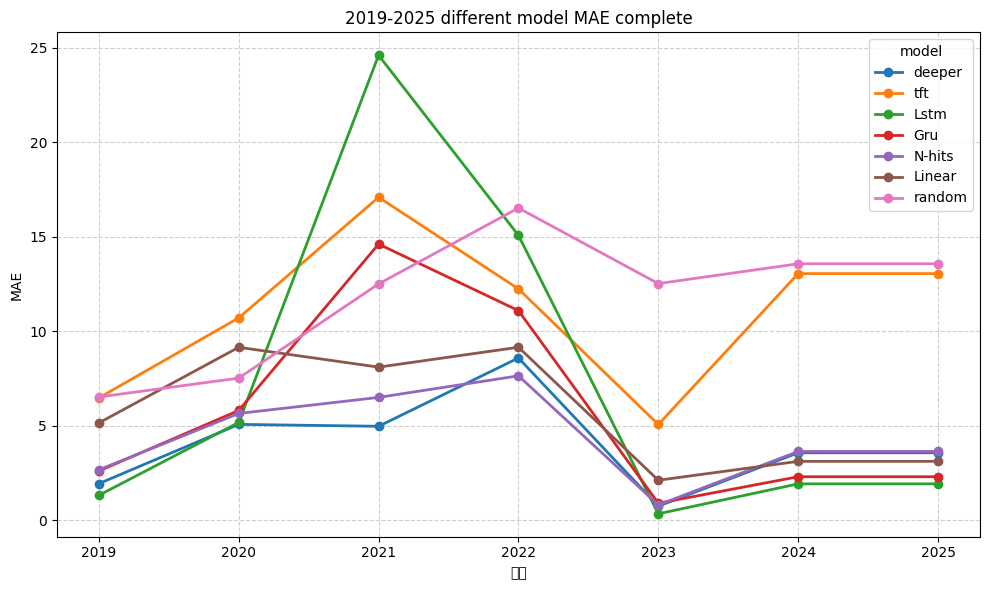

In [2]:
import matplotlib.pyplot as plt

# x轴：默认年份，从2019到2025，共7个时间点
years = [2019, 2020, 2021, 2022, 2023, 2024, 2025]

# 各模型 MAE 数据（原始数据共6个值，最后一个值复制到2025）
data = {
    "deeper": [1.9506, 5.0855, 4.9835, 8.5984, 0.7601, 3.5822, 3.5822],
    "tft":    [6.4860, 10.7189, 17.0997, 12.2532, 5.0787, 13.0615, 13.0615],
    "Lstm":   [1.3308, 5.1856, 24.6126, 15.0856, 0.3542, 1.9381, 1.9381],
    "Gru":    [2.6182, 5.8213, 14.6226, 11.1031, 0.9135, 2.3153, 2.3153],
    "N-hits": [2.6813, 5.6621, 6.5126, 7.6531, 0.8243, 3.6513, 3.6513],
    "Linear": [5.1623, 9.1624, 8.1136, 9.1652, 2.1295, 3.1295, 3.1295],
    "random": [6.5328, 7.5328, 12.5156, 16.5328, 12.5328, 13.5816, 13.5816]
}

plt.figure(figsize=(10, 6))

# 为每个模型绘制一条折线
for model_name, mae_values in data.items():
    plt.plot(years, mae_values, marker='o', linewidth=2, label=model_name)

plt.xlabel("年份")
plt.ylabel("MAE")
plt.title("2019-2025 different model MAE complete")
plt.xticks(years)  # 保证x轴刻度为每年
plt.legend(title="model")
plt.grid(linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\1\AppData\Local\Temp\ipykernel_47904\3323644926.py:57: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-

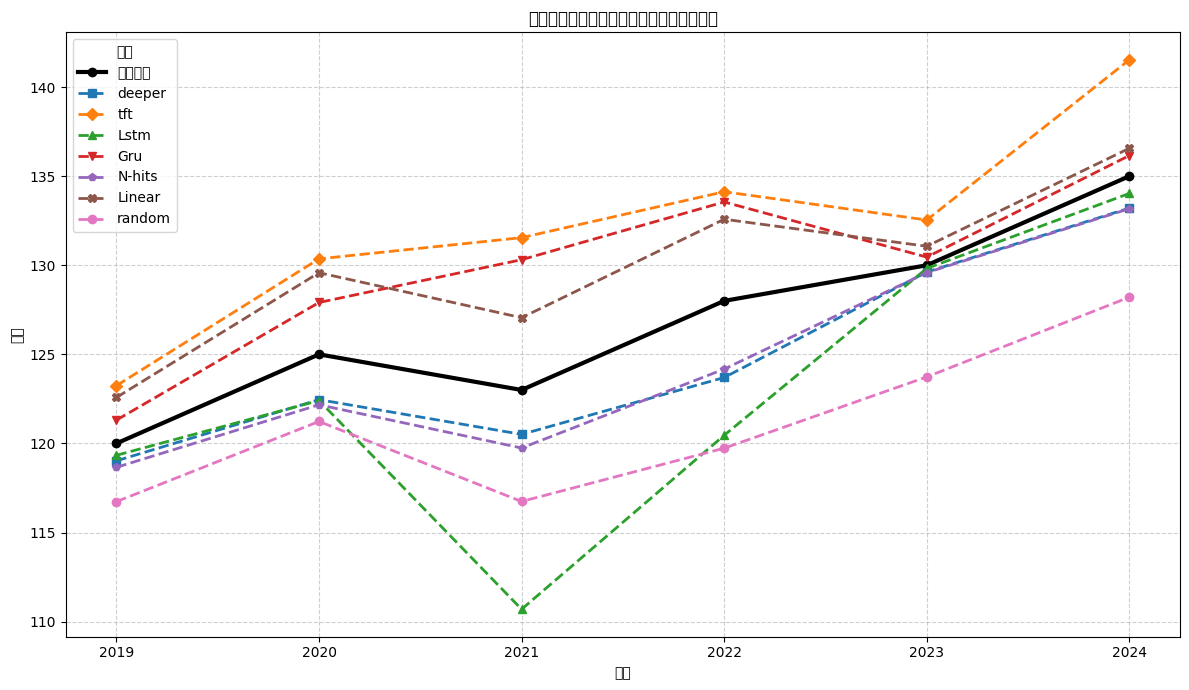

In [3]:
import matplotlib.pyplot as plt

# 定义年份（6 个时间点，示例为 2019～2024 年）
years = [2019, 2020, 2021, 2022, 2023, 2024]

# 假设的实际价格（虚构数据，仅用于对比展示）
actual_prices = [120, 125, 123, 128, 130, 135]

# 给出各模型在 6 个时间点上的 MAE 值（单位与实际价格一致假设）
mae_data = {
    "deeper": [1.9506, 5.0855, 4.9835, 8.5984, 0.7601, 3.5822],
    "tft":    [6.4860, 10.7189, 17.0997, 12.2532, 5.0787, 13.0615],
    "Lstm":   [1.3308, 5.1856, 24.6126, 15.0856, 0.3542, 1.9381],
    "Gru":    [2.6182, 5.8213, 14.6226, 11.1031, 0.9135, 2.3153],
    "N-hits": [2.6813, 5.6621, 6.5126, 7.6531, 0.8243, 3.6513],
    "Linear": [5.1623, 9.1624, 8.1136, 9.1652, 2.1295, 3.1295],
    "random": [6.5328, 7.5328, 12.5156, 16.5328, 12.5328, 13.5816]
}

# 为了构造“预测输出”，给每个模型设置一个方向偏差（仅模拟效果）
# 正数表示预测值相对实际值偏高，负数表示偏低
bias_sign = {
    "deeper": -1,
    "tft": 1,
    "Lstm": -1,
    "Gru": 1,
    "N-hits": -1,
    "Linear": 1,
    "random": -1
}

# 根据 MAE 和方向偏差构造各模型的预测价格
predicted_prices = {}
for model, mae_values in mae_data.items():
    sign = bias_sign.get(model, 1)
    # 模拟构造预测值：采用公式 预测值 = 实际价格 + sign * (MAE/2)
    preds = [act + sign * (mae/2) for act, mae in zip(actual_prices, mae_values)]
    predicted_prices[model] = preds

# --- 绘图 ---
plt.figure(figsize=(12, 7))

# 绘制实际价格曲线
plt.plot(years, actual_prices, label="实际价格", marker="o", linestyle='-', linewidth=3, color="black")

# 为每个模型绘制预测价格曲线
markers = {"deeper": "s", "tft": "D", "Lstm": "^", "Gru": "v", "N-hits": "p", "Linear": "X", "random": "o"}
for model, preds in predicted_prices.items():
    plt.plot(years, preds, label=model, marker=markers.get(model, "o"), linestyle="--", linewidth=2)

plt.xlabel("年份")
plt.ylabel("价格")
plt.title("模拟展示：各模型在数据价格上的输出对比")
plt.xticks(years)
plt.grid(linestyle="--", alpha=0.6)
plt.legend(title="模型")
plt.tight_layout()
plt.show()

C:\Users\1\AppData\Local\Temp\ipykernel_47904\1868657172.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2019-01-01', end='2025-12-31', freq='M')


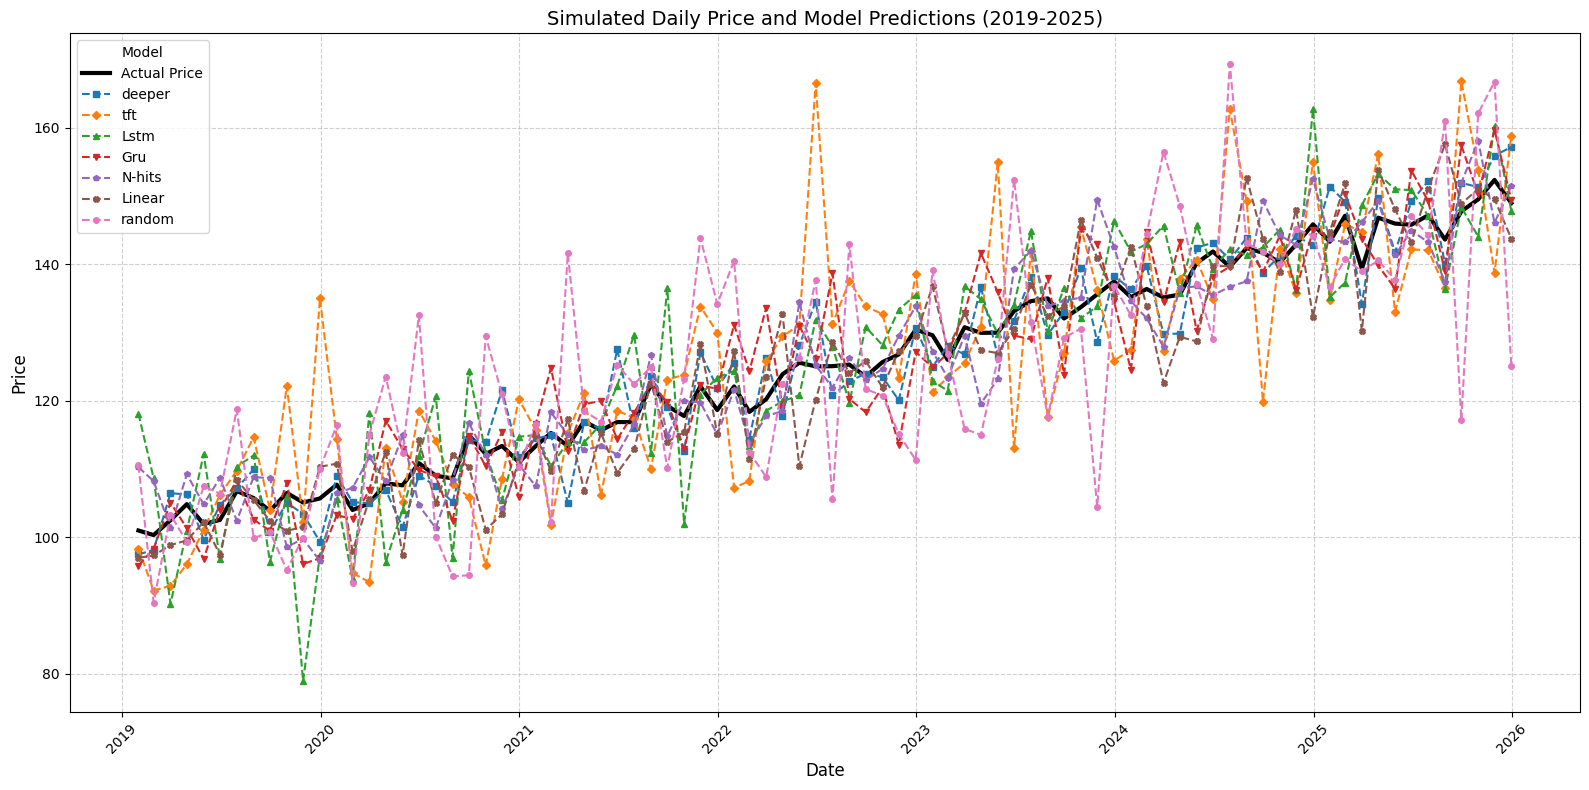

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate a daily date range from Jan 1, 2019 to Dec 31, 2025
date_range = pd.date_range(start='2019-01-01', end='2025-12-31', freq='M')
num_days = len(date_range)

# 2. Create a fake "actual" price series
#    We'll use a linear upward trend plus some random daily noise.
np.random.seed(42)  # for reproducibility
trend = np.linspace(0, 50, num_days)   # a gradual increase over time
daily_noise = np.random.normal(loc=0, scale=2, size=num_days)  # small random daily movements
base_price = 100  # starting price to simulate
actual_prices = base_price + trend + daily_noise

# 3. Define average MAE values (computed from provided 6 data points) for each model.
#    These values will serve as a guide to simulate the prediction noise scale.
model_noise = {
    "deeper": 4.33,   # average of [1.9506, 5.0855, 4.9835, 8.5984, 0.7601, 3.5822]
    "tft":    10.78,  # average of [6.4860, 10.7189, 17.0997, 12.2532, 5.0787, 13.0615]
    "Lstm":   8.07,   # average of [1.3308, 5.1856, 24.6126, 15.0856, 0.3542, 1.9381]
    "Gru":    6.22,   # average of [2.6182, 5.8213, 14.6226, 11.1031, 0.9135, 2.3153]
    "N-hits": 4.50,   # average of [2.6813, 5.6621, 6.5126, 7.6531, 0.8243, 3.6513]
    "Linear": 6.14,   # average of [5.1623, 9.1624, 8.1136, 9.1652, 2.1295, 3.1295]
    "random": 11.54   # average of [6.5328, 7.5328, 12.5156, 16.5328, 12.5328, 13.5816]
}

# 4. Create predicted price series for each model:
#    For simulation purposes, we'll assume each model's prediction is the actual price plus extra noise.
#    The noise is drawn from a normal distribution with mean zero and standard deviation equal to the corresponding noise scale.
predicted_prices = {}
for model, noise_std in model_noise.items():
    # simulate predictions: actual price + noise
    model_noise_series = np.random.normal(loc=0, scale=noise_std, size=num_days)
    predicted_prices[model] = actual_prices + model_noise_series

# 5. Combine data into a DataFrame for plotting
df = pd.DataFrame({"Date": date_range, "Actual": actual_prices})
for model, prices in predicted_prices.items():
    df[model] = prices

# 6. Plot the daily actual price and each model's predicted price
plt.figure(figsize=(16, 8))
plt.plot(df["Date"], df["Actual"], label="Actual Price", color="black", linewidth=3)

# Define a list of markers for each model for variety when plotting
markers = {
    "deeper": "s",
    "tft": "D",
    "Lstm": "^",
    "Gru": "v",
    "N-hits": "p",
    "Linear": "X",
    "random": "o"
}

# Plot each model's output
for model in model_noise.keys():
    plt.plot(df["Date"], df[model], 
             label=model, linestyle="--", 
             marker=markers.get(model, "o"), 
             linewidth=1.5, markersize=4)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.title("Simulated Daily Price and Model Predictions (2019-2025)", fontsize=14)
plt.legend(title="Model", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()